# AFM_Analysis_Notebook

This notebook loads, extracts, and analyzes .ibw files from AFM systems. 

## Load Data

In [269]:
import igor2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# Load file
ibw = igor2.binarywave.load("GV007_STO0000.ibw") #insert file name here from current directory

# Extract data
data = ibw['wave']['wData']

# Extract metadata 
metadata = ibw['wave']['note']  

print("Data shape:", data.shape) #256x256 pixels with 4 channels (e.g. height, amplitude etc)


Data shape: (256, 256, 4)


## Organize meta data

In [270]:
# Decode metadata
note = metadata.decode('utf-8', errors='ignore')

# Parse into dictionary
def parse_metadata(note):
    meta = {}
    for line in note.splitlines():
        if ":" in line:
            key, value = line.split(":", 1)
            meta[key.strip()] = value.strip()
    return meta

meta_dict = parse_metadata(note)

# Convert to DataFrame
meta_df = pd.DataFrame(meta_dict.items(), columns=["Field", "Value"])

# If we want to visualize all rows
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

meta_df


,Field,Value
0,ScanSize,5e-06
1,FastScanSize,5e-06
2,SlowScanSize,5e-06
3,ScanRate,1.0016
4,XOffset,0
...,...,...
835,ColorMap 3,VioletOrangeYellow
836,EndHeadTemp,31.875 C
837,EndScannerTemp,26.5 C
838,EndHeaterTemp,23.434 C


## Plot Raw Data Channels

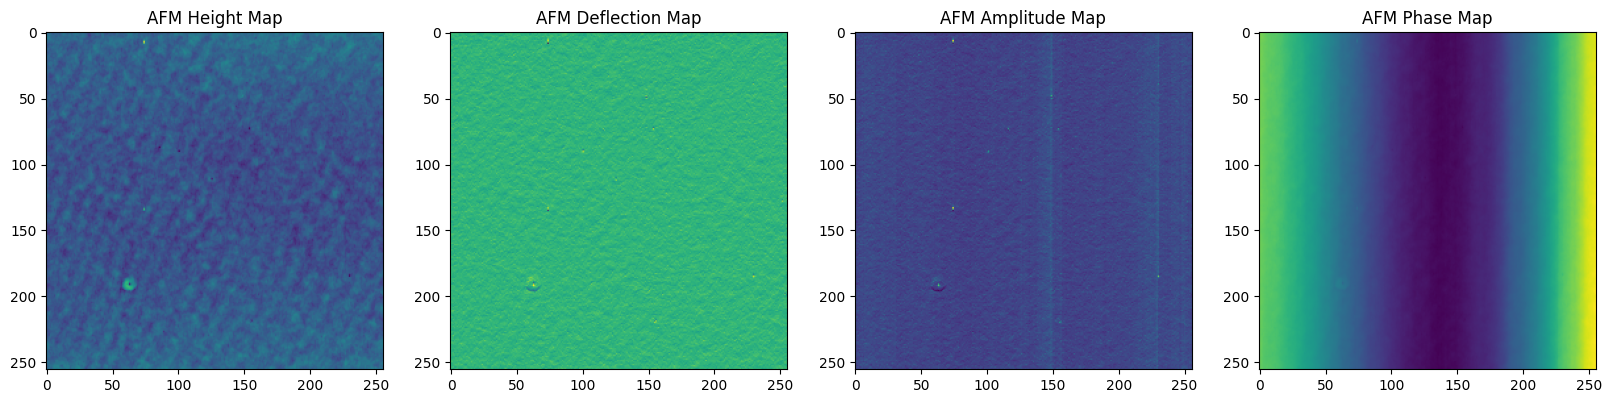

In [271]:
fig, ax = plt.subplots(1,4,figsize=(20, 10))

height = data[:, :, 0]/1E-9 # in nm
defl = data[:, :, 1]
amp = data[:, :, 2]
phase = data[:, :, 3]

names = ['Height', 'Deflection', 'Amplitude', 'Phase']
total = [height,defl,amp,phase]

def plotter(total):
    for index, x in enumerate(total):
        ax[index].imshow(x, cmap='viridis')
        ax[index].set_title('AFM {} Map'.format(names[index]))

plotter(total)

## Filtering

### Median Filter

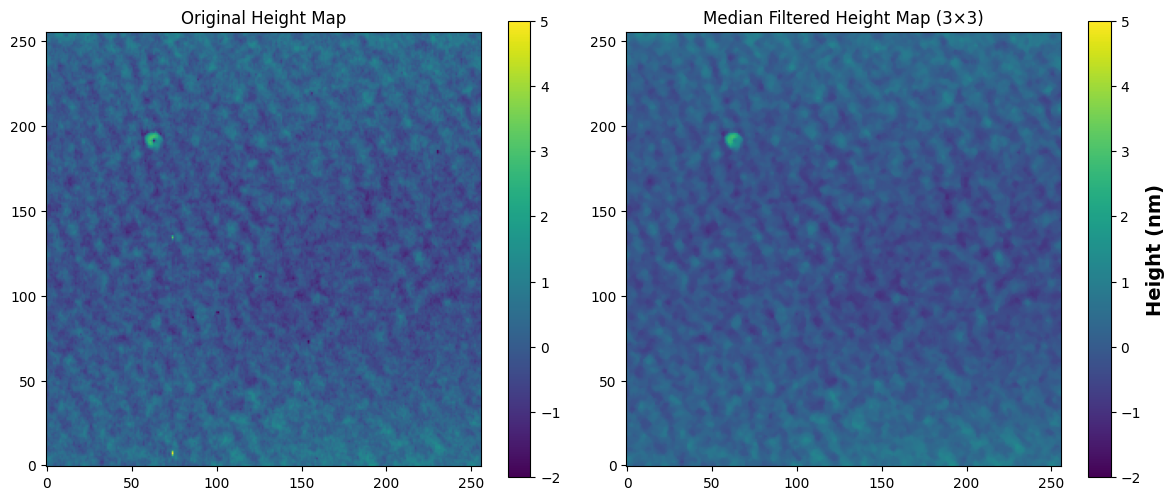

In [272]:
# Apply a 3×3 median filter
filtered = median_filter(height.astype(float), size=3)

# Plot original vs filtered
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
im = plt.imshow(height, cmap='viridis', origin='lower',vmin=-2,vmax=5)
plt.title("Original Height Map")
plt.colorbar(im)

plt.subplot(1, 2, 2)
im = plt.imshow(filtered, cmap='viridis', origin='lower',vmin=-2,vmax=5)
plt.title("Median Filtered Height Map (3×3)")
plt.colorbar().set_label('Height (nm)', size=14, weight='bold')

plt.tight_layout()
plt.show()


### Guassian Filter

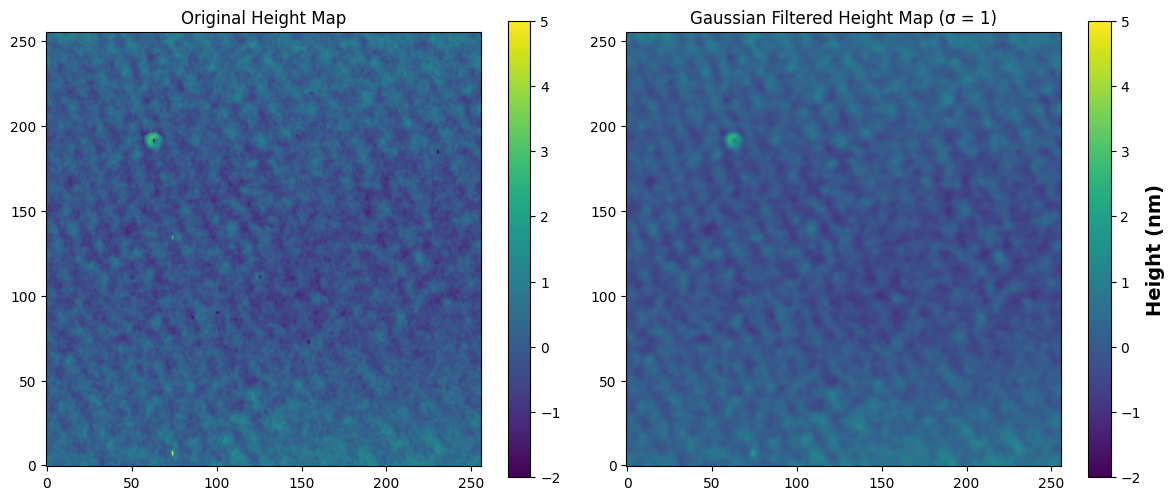

In [273]:
# Apply a Gaussian filter with sigma = 1 (common for AFM)
filtered = gaussian_filter(height.astype(float), sigma=1)

# Plot original vs filtered
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
im = plt.imshow(height, cmap='viridis', origin='lower',vmin=-2,vmax=5)
plt.title("Original Height Map")
plt.colorbar()

plt.subplot(1, 2, 2)
im = plt.imshow(filtered, cmap='viridis', origin='lower',vmin=-2,vmax=5)
plt.title("Gaussian Filtered Height Map (σ = 1)")
plt.colorbar().set_label('Height (nm)', size=14, weight='bold')

plt.tight_layout()
plt.show()


## Metric Extraction

### Sa and Sq

In [274]:

# Compute mean height
Z_mean = np.mean(height.astype(float))

# Sa: mean absolute deviation
Sa = np.mean(np.abs(height.astype(float) - Z_mean))

# Sq: RMS roughness
Sq = np.sqrt(np.mean((height.astype(float) - Z_mean)**2))

print("Sa:", Sa.round(4))
print("Sq:", Sq.round(4))


Sa: 0.3273
Sq: 0.4106


### Spatially Filtered Roughness

In [275]:
def spatially_filtered_roughness(height, sigma=1.0):
    Z = np.nan_to_num(height.astype(float))
    
    # Gaussian low-pass filter (waviness)
    waviness = gaussian_filter(Z, sigma=sigma)
    
    # Subtract to get roughness component
    roughness = Z - waviness
    
    # Compute Sa and Sq on roughness
    r_mean = np.mean(roughness)
    
    Sa_r = np.mean(np.abs(roughness - r_mean))
    Sq_r = np.sqrt(np.mean((roughness - r_mean)**2))
    
    return Sa_r, Sq_r, waviness, roughness

Sa_r, Sq_r, waviness, roughness = spatially_filtered_roughness(height, sigma=2)

print("Spatially Filtered Sa (short-wavelength):", Sa_r.round(4))
print("Spatially Filtered Sq (short-wavelength):", Sq_r.round(4))



Spatially Filtered Sa (short-wavelength): 0.1572
Spatially Filtered Sq (short-wavelength): 0.2007


<Figure size 1200x400 with 0 Axes>

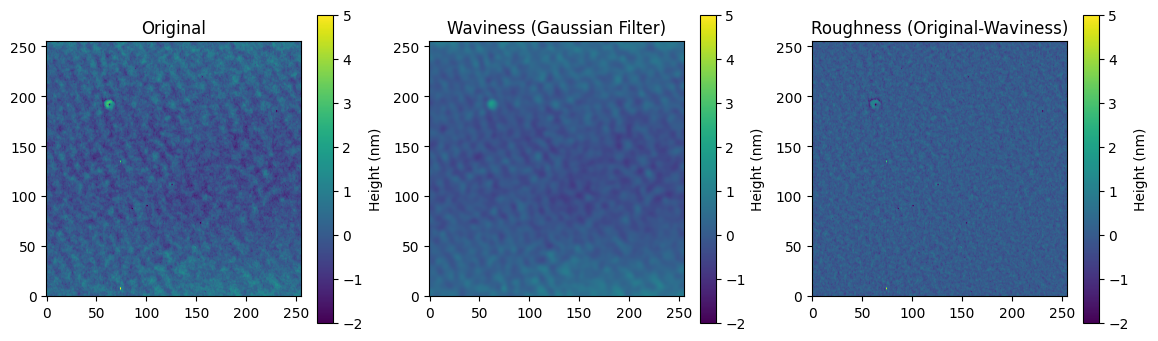

In [276]:
plt.figure(figsize=(12, 4))

names = ['Original', 'Waviness (Gaussian Filter)', 'Roughness (Original-Waviness)']
plots = [height,waviness,roughness]

fig, ax = plt.subplots(1,3,figsize=(14,8))

for index, x in enumerate(names):
    ax[index] = plt.subplot(1, 3, index+1)
    im = ax[index].imshow(plots[index], cmap='viridis', origin='lower',vmin=-2,vmax=5)
    ax[index].set_title(x)
    cbar = fig.colorbar(im, ax=ax[index],shrink=0.5)
    cbar.set_label('Height (nm)')



## Unsupervised Periodicity Identification

Here we take the Gaussian filtered array and plot the PSD to identify underlying periodicity. As observed by the two symmetric lobes, the repeating diagonal step heights of the AFM image are identified. 

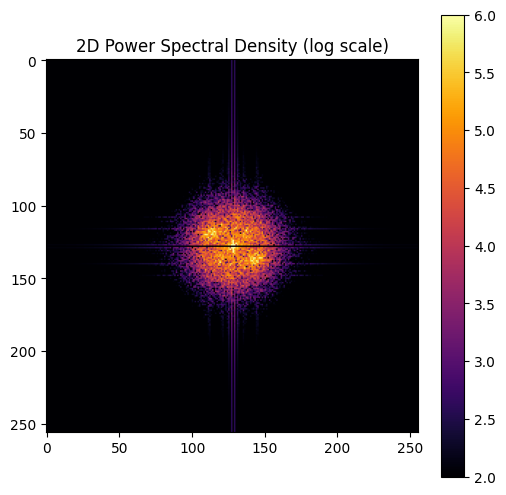

In [278]:
def compute_psd_2d(height):
    Z = height.astype(float)

    # Subtract mean
    Z = Z - np.mean(Z)

    # 2D FFT
    F = np.fft.fft2(Z)

    # Shift zero frequency to center
    F_shift = np.fft.fftshift(F)

    # Compute PSD
    PSD = np.abs(F_shift)**2

    return PSD

PSD = compute_psd_2d(waviness)

plt.figure(figsize=(6,6))
plt.imshow(np.log10(PSD + 1e-15), cmap='inferno',vmin=2,vmax=6)
plt.title("2D Power Spectral Density (log scale)")
plt.colorbar()
plt.show()
